# 编程作业4

请利用图像处理课程所学的相关技术，求图像Fig01.tif中米粒的个数及其各个米粒的大小。

### 实现思路：



- 1. 将图像转化为灰度图像，并查看其灰度值分布情况
- 2. 选择合适的阈值，将图像二值化，得到二值图像
- 3. 寻找轮廓并绘制轮廓
- 4. 计算米粒的个数及其各个米粒的大小

### 执行指引：
请依次运行以下代码块，注意代码块的阅读顺序即为执行顺序。

In [1]:
# import the necessary packages
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the function to show the histogram of a grayscale image.
def grayHist(grayImage, title="Gray Level Histogram", xlabel="Gray Level", ylabel="Frequency"):
    """
    Plot the histogram of a grayscale image.

    Parameters:
    - grayImage: A grayscale image array.
    - title: Title of the histogram.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    """
    plt.hist(grayImage.ravel(), bins=256)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

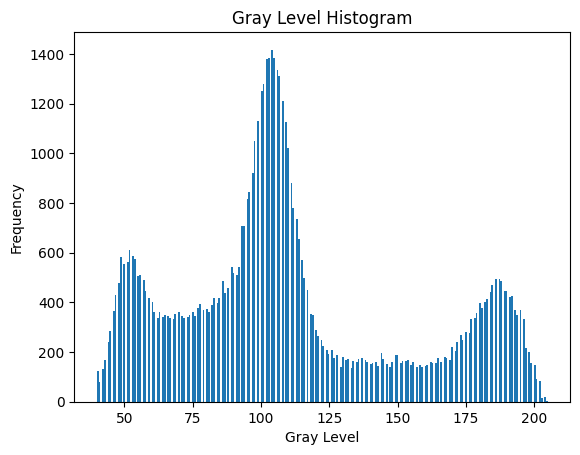

In [3]:
# Read the image and convert it to grayscale
img_path = "Fig01.tif"
img = cv.imread(img_path)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Show the histogram of the grayscale image
grayHist(gray_img)

从灰度图中可以看出有三个峰，因此难以通过单一阈值进行有效分割，所以应使用 OTSU 或者 TRIANGLE 的优化方法。

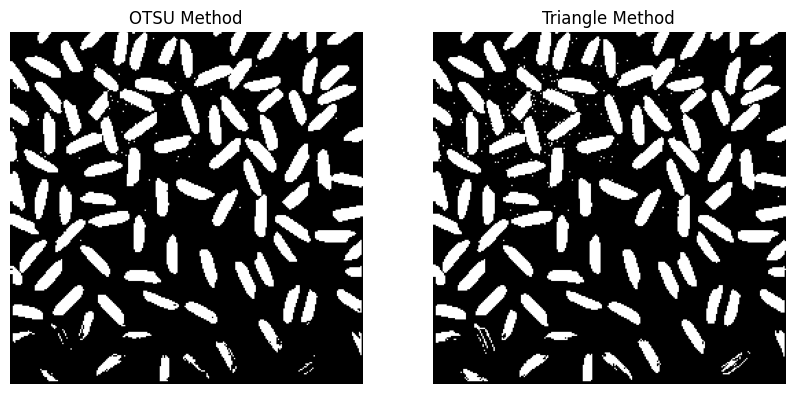

In [4]:
ret, otsu = cv.threshold(gray_img, 0, 255, 
cv.THRESH_BINARY | cv.THRESH_OTSU)
ret2, triangle = cv.threshold(gray_img, 0, 255, 
cv.THRESH_BINARY | cv.THRESH_TRIANGLE)

# 使用cv展示图像会弹出两个窗口，ipykernel 会维持两个窗口的生命周期，所以使用 matplotlib 展示图像 

# cv.imshow("otsu", otsu)
# cv.imshow("triangle", triangle)
# cv.waitKey(0)

# 使用 matplotlib 展示图像
plt.figure(figsize=(10, 5))

# 显示 OTSU 阈值处理后的图像
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.imshow(otsu, cmap='gray')
plt.title('OTSU Method')
plt.axis('off')  # 不显示坐标轴

# 显示 Triangle 阈值处理后的图像
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.imshow(triangle, cmap='gray')
plt.title('Triangle Method')
plt.axis('off')  # 不显示坐标轴

plt.show()

从图中看出，图像受噪点影响，应首先去噪以便于后续处理。根据上次实验的经验，选择自适应中值滤波尝试去噪。

In [6]:
# 定义自适应中值滤波函数
def adaptive_median_filter(image, max_kernel_size):
    """
    Apply adaptive median filter to an image.
    :param image: numpy.ndarray, the image to apply the filter on.
    :param max_kernel_size: int, the maximum size of the median filter kernel.
    :return: numpy.ndarray, the filtered image.
    """
    temp_image = image.copy()
    height, width = temp_image.shape
    filtered_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            k = 1
            z_min, z_med, z_max = 0, 0, 0
            s_max = max_kernel_size // 2
            while k <= s_max:
                kernel = temp_image[max(i - k, 0):min(i + k + 1, height), max(j - k, 0):min(j + k + 1, width)]
                z_min = np.min(kernel)
                z_med = np.median(kernel)
                z_max = np.max(kernel)
                if z_min < z_med < z_max:
                    break
                k += 1
            if z_min < temp_image[i, j] < z_max:
                filtered_image[i, j] = temp_image[i, j]
            else:
                filtered_image[i, j] = z_med
    return filtered_image


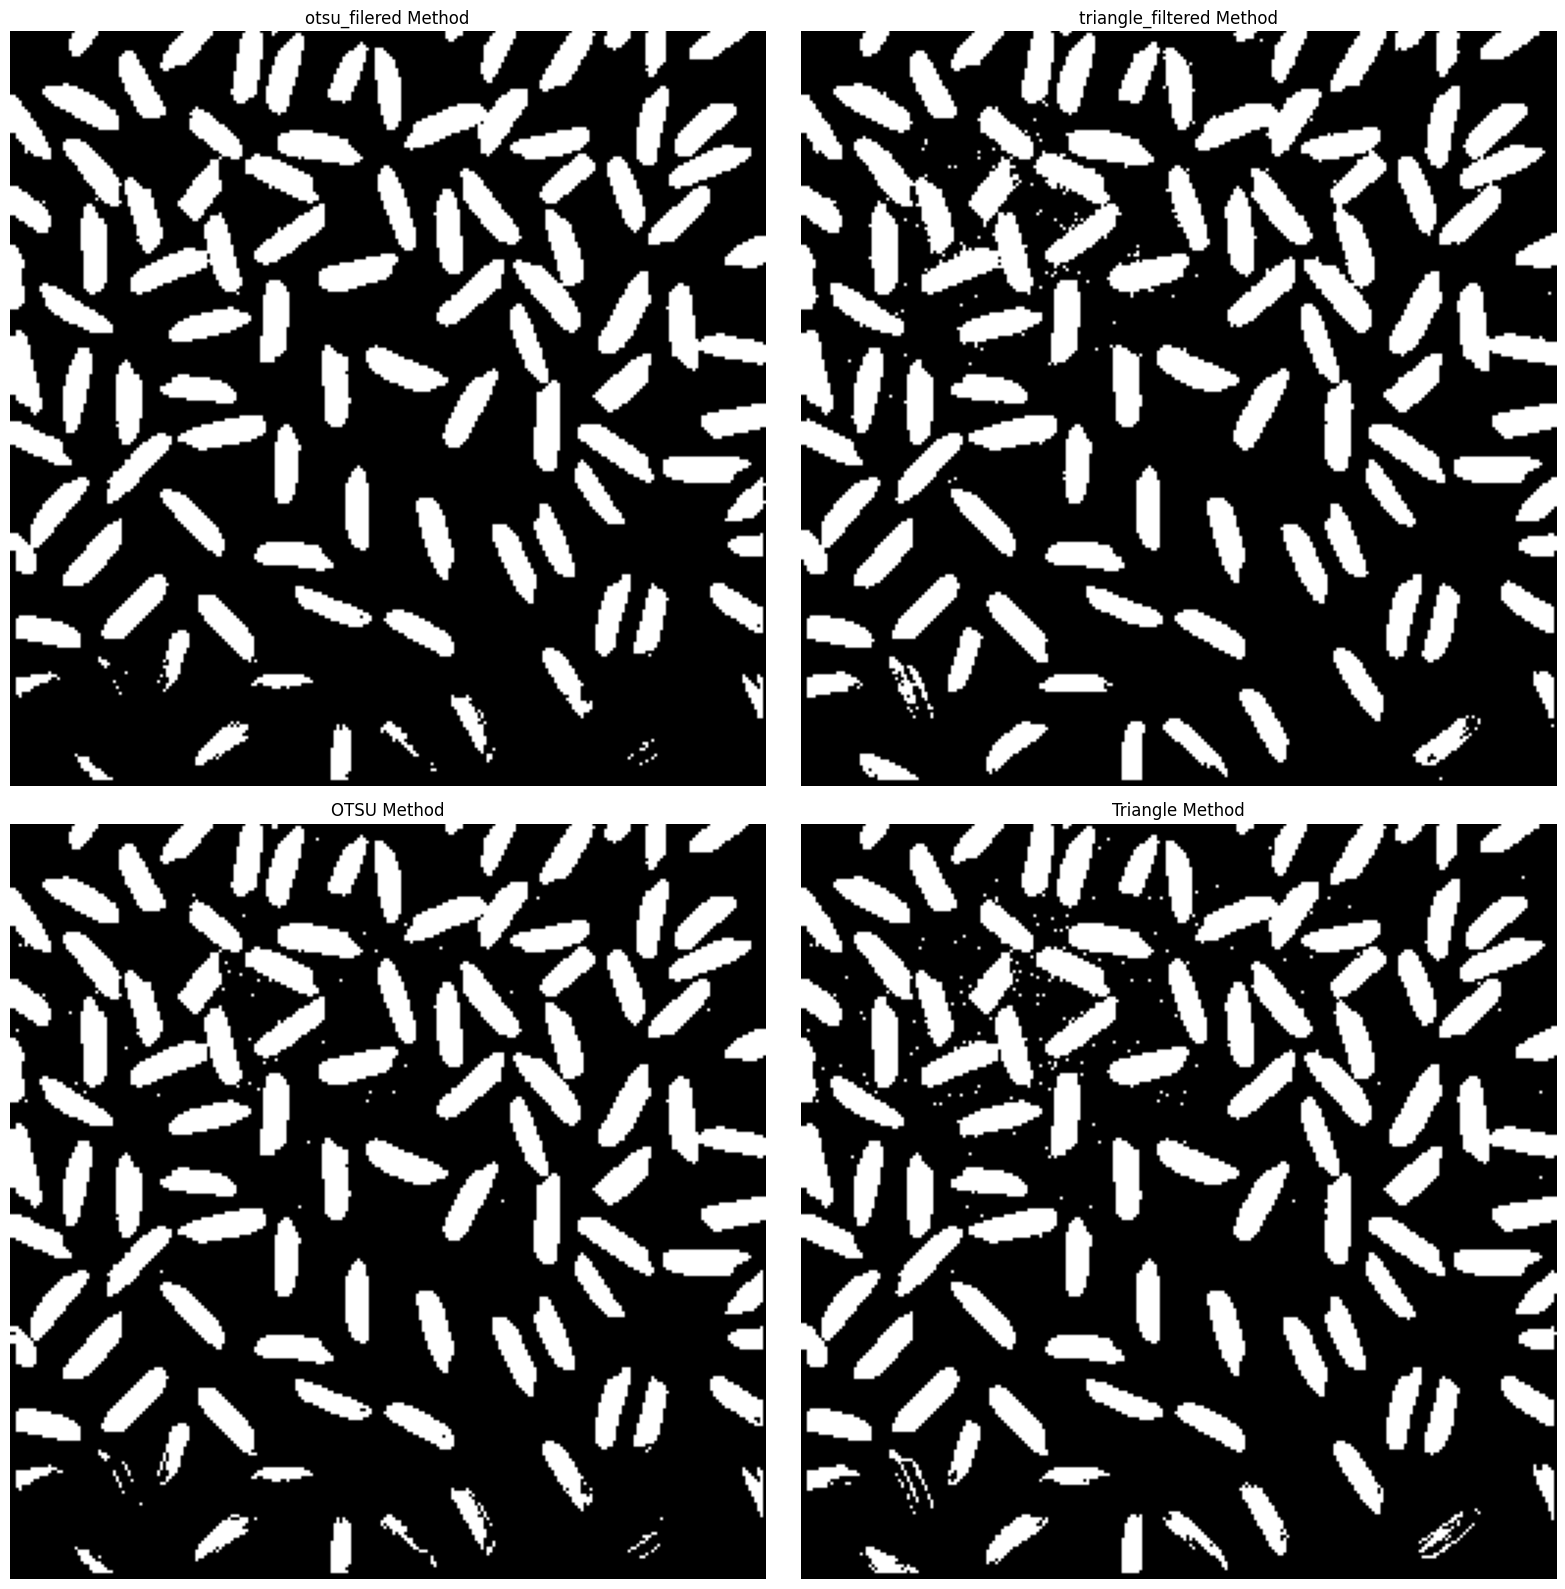

In [7]:
max_kernel_size = 7

filtered_image =  adaptive_median_filter(gray_img,max_kernel_size=max_kernel_size)


ret, otsu_filered = cv.threshold(filtered_image, 0, 255, 
cv.THRESH_BINARY | cv.THRESH_OTSU)
ret2, triangle_filtered = cv.threshold(filtered_image, 0, 255, 
cv.THRESH_BINARY | cv.THRESH_TRIANGLE)

# 使用cv展示图像会弹出两个窗口，ipykernel 会维持两个窗口的生命周期，所以使用 matplotlib 展示图像 

# cv.imshow("otsu", otsu)
# cv.imshow("triangle", triangle)
# cv.waitKey(0)

# 使用 matplotlib 展示图像
plt.figure(figsize=(16, 16))

# 显示 OTSU 阈值处理后的滤波后图像
plt.subplot(2, 2, 1)  # 1行2列的第1个
plt.imshow(otsu_filered, cmap='gray')
plt.title('otsu_filered Method')
plt.axis('off')  # 不显示坐标轴

# 显示 Triangle 阈值处理后滤波后的图像
plt.subplot(2, 2, 2)  # 1行2列的第2个
plt.imshow(triangle_filtered, cmap='gray')
plt.title('triangle_filtered Method')
plt.axis('off')  # 不显示坐标轴


# 显示 OTSU 阈值处理后的图像
plt.subplot(2, 2, 3)  # 1行2列的第1个
plt.imshow(otsu, cmap='gray')
plt.title('OTSU Method')
plt.axis('off')  # 不显示坐标轴

# 显示 Triangle 阈值处理后的图像
plt.subplot(2, 2, 4)  # 1行2列的第2个
plt.imshow(triangle, cmap='gray')
plt.title('Triangle Method')
plt.axis('off')  # 不显示坐标轴

plt.tight_layout()
plt.show()

从图中看出，即便是采用中值滤波去噪后再进行 OTSU 分割，也会出现米粒的形态受影响的情况，尝试在这种情况下画出米粒的轮廓，发现轮廓不完整，因此应该采用其他方法进行分割。下面尝试形态学开运算去除噪点，再进行分割。

In [8]:
# Perform open operation on the gray_img

# plain implementation
# kernels = np.ones((5, 5), np.uint8)
# img_erode = cv.erode(gray_img, kernels, iterations=5)
# img_dilation = cv.dilate(img_erode, kernels, iterations=5)

# img_interface = gray_img - img_dilation
# 显示结果的柱状图，你需要定义grayHist函数
# grayHist(img_difference)


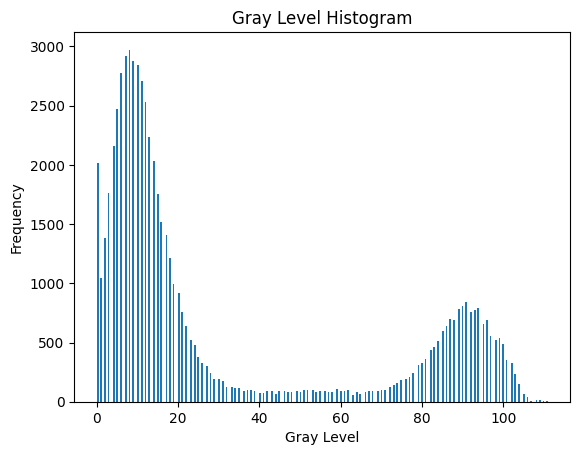

In [9]:
# Employ the morphologyEx function to perform open operation on the gray_img

# 使用getStructuringElement创建与之前相同的5x5矩形结构元素（尝试使用Ellipse形状的结构元，结果差别不大）
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))

# 使用morphologyEx进行开运算，设置迭代次数与之前一致
img_opening = cv.morphologyEx(gray_img, cv.MORPH_OPEN, kernel, iterations=5)

# 计算原始图像和开运算之后图像的差，用于强调被开运算修改的区域
img_difference = cv.subtract(gray_img, img_opening)

# Show the histogram of the grayscale image.
grayHist(img_difference)

从图中可以看出，经过开运算后，灰度图只有两个峰值，可以使用简单的二值化方法进行分割。

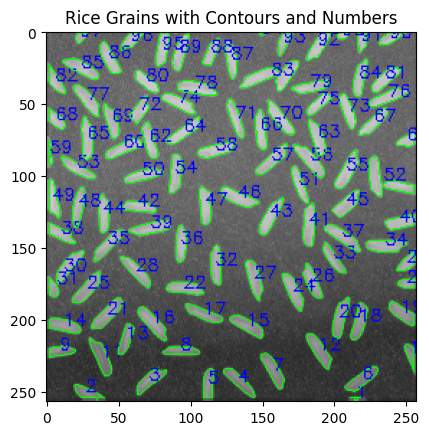

(98,
 array([[  0. ,   5. ],
        [  1. ,  97.5],
        [  2. , 149.5],
        [  3. , 151. ],
        [  4. , 118. ],
        [  5. , 167.5],
        [  6. , 174.5],
        [  7. , 109. ],
        [  8. ,  99.5],
        [  9. ,  62. ],
        [ 10. , 181.5],
        [ 11. , 180. ],
        [ 12. , 120.5],
        [ 13. , 153. ],
        [ 14. , 168. ],
        [ 15. , 191. ],
        [ 16. , 147. ],
        [ 17. , 164. ],
        [ 18. , 145. ],
        [ 19. , 176. ],
        [ 20. , 195. ],
        [ 21. , 159. ],
        [ 22. ,  59.5],
        [ 23. , 175.5],
        [ 24. , 180. ],
        [ 25. , 151.5],
        [ 26. , 178.5],
        [ 27. , 166.5],
        [ 28. ,  87.5],
        [ 29. , 225. ],
        [ 30. ,   2. ],
        [ 31. , 161. ],
        [ 32. , 119.5],
        [ 33. , 182.5],
        [ 34. , 157. ],
        [ 35. , 147.5],
        [ 36. , 183. ],
        [ 37. , 121. ],
        [ 38. , 177.5],
        [ 39. , 140.5],
        [ 40. , 191. ],
        [ 4

In [11]:

# binarize the image 
ret, binary = cv.threshold(img_difference, 60, 255, cv.THRESH_BINARY)
contours, hierarchy = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# 使用numpy的向量化操作计算所有轮廓的面积
contour_area = np.array([cv.contourArea(contour) for contour in contours])

# 剔除面积为0的轮廓
contours = [contour for contour, area in zip(contours, contour_area) if area > 0]

# 使用enumerate结合列表推导式来创建一个包含序号和面积的数组
contour_areas_with_indices = np.array([(index, cv.contourArea(contour)) for index, contour in enumerate(contours)])


# 计算米粒数量，计算非零面积的轮廓数量
rice_count = len(contours)


# 绘制轮廓和序号
for i, contour in enumerate(contours):
    cv.drawContours(img, contours, i, (0, 255, 0), 1)
    # 计算轮廓的中心点并绘制序号
    M = cv.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv.putText(img, str(i+1), (cx, cy), cv.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)


# 显示带有轮廓和序号的图像
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Rice Grains with Contours and Numbers")
plt.savefig("rice_grains_with_contours_and_numbers.png")
plt.show()

# 返回米粒数量
rice_count,contour_areas_with_indices


#### 结果分析和展望
图中已经标注出米粒的序号，在输出中给出了米粒的个数和各个米粒的大小。但从图中可以看到，这种方法对粘连的现象无法有效分割，因此未来可以尝试采用其他方法对粘连的米粒进行分割。